In [4]:
#IMPORTS

from scipy.stats import norm
from matplotlib import pyplot as plt 
import numpy as np
import time
np.set_printoptions(threshold=np.inf)
np.set_printoptions(suppress = True)

In [59]:
#INITIALIZE PARAMETERS - FROM HALL AND MURPHY (2001) - 67% of wealth in stock

#Option parameters
S0_init = 30        #S_0
K_init = 30         #Strike price (=S_0)
T_init = 10         #Maturity
v_init = 3          #Vesting period
r_init = 0.06       #RF rate
N_init = 50         #Height of tree
N_init_r = 50       #Height of tree for R option
sigma_init = 0.3    #Volatility

#For R option only: alpha is percentage that gets converted to stock, gamma the "risk premium"
alpha_init = 0.75
gamma_init = 0.1


#Agent's parameters
rho_init = 2.5      #>1 because agent is risk-averse
c_init = 1700000    #Agent's initial wealth
n_s_init = 110000   #Number of shares
n_o_init = 300      #Number of options

In [235]:
#INITIALIZE PARAMETERS - FROM LAU AND KWOK (2005)

#Option parameters
S0_init = 0.1       #S_0
K_init = 0.1        #Strike price (=S_0)
T_init = 5          #Maturity
v_init = 0          #Vesting period
r_init = 0.06       #RF rate
N_init = 50         #Height of tree
N_init_r = 50       #Height of tree for R option
sigma_init = 0.3    #Volatility

#For R option only: alpha is percentage that gets converted to stock, gamma the "risk premium"
alpha_init = 0.75
gamma_init = 0.1


#Agent's parameters
rho_init = 2        #>1 because agent is risk-averse
c_init = 75         #Agent's initial wealth
n_s_init = 750      #Number of shares
n_o_init = 10       #Number of options

In [6]:
#COMPUTE UTILITY (W AS INPUT) AND INVERSE OF UTILITY (U AS INPUT)

#Compute power utility
def utility(w, rho): 
    if rho == 1:
        return np.log(w)
    else:
        return (w**(1-rho)) / (1-rho)


#Compute inverse of iso-elastic utility - needed to compute CE
def u_minus(u, rho):
    if rho==1:
        return np.exp(u)
    else:
        return (u*(1-rho))**(1/(1-rho))

In [87]:
#COMPUTE CE OF RN OPTION

def CE_rn(S0, K, T, v, r, N, sigma, rho, n_s, n_o, c):
    if n_o == 0:
        return 0

    # Init values
    dt = 1 / N  # number of steps
    u = np.exp(sigma * np.sqrt(dt))  # using CRR method with (constant) volatility
    d = 1 / u  # to maintain the triangular structure of the tree (i.e., recombinant tree)
    q_u = ((np.exp(r * dt / 2) - np.exp(-sigma * np.sqrt(dt / 2))) /
           (np.exp(sigma * np.sqrt(dt / 2)) - np.exp(-sigma * np.sqrt(dt / 2)))) ** 2
    q_d = ((np.exp(sigma * np.sqrt(dt / 2)) - np.exp(r * dt / 2)) /
           (np.exp(sigma * np.sqrt(dt / 2)) - np.exp(-sigma * np.sqrt(dt / 2)))) ** 2  # Probability of down move
    q_m = 1 - q_u - q_d

    # Build up stock price tree to compute exercise value
    S = np.zeros((T * N + 1, T * N + 1))
    U = np.zeros((T * N + 1, T * N + 1))

    for n in range(0, T * N + 1):
        for j in range(0, n + 1):
            S[j, n] = S0 * u ** j * d ** (n - j)  # j is #ups
            w = c * ((1 + (r / N)) ** n) + n_s * S[j, n] + n_o * np.maximum(0, S[j, n] - K)
            U[j, n] = utility(w, rho)  # Exercise value

    # Dynamic programming
    for i in np.arange(T * N - 1, -1, -1):  # we start from the lowest node one step before maturity
        S = S0 * u ** np.arange(i + 1) * d ** (i - np.arange(i + 1))
        vested = (i >= v * N)

        cont_value = q_u * U[1:, i + 1] + q_d * U[:-1, i + 1] + q_m * U[:-1, i]
        excs_value = U[:-1, i]

        U[:-1, i] = np.where(vested, np.maximum(cont_value, excs_value), cont_value)

    E_c = (u_minus(U[0, 0], rho) - c - n_s * S0) / n_o

    return E_c


In [83]:
#COMPUTE CE OF R OPTION 

def CE_r(S0,K,T,v,r,N,sigma,rho, alpha,gamma, n_s,n_o,c):

  #if n_o == 0:
   # return 0  
    
  #Init values
  dt = 1/N                        #number of steps
  u = np.exp(sigma * np.sqrt(dt)) #using CRR method with (constant) volatility
  d = 1/u                         #to maintain the triangular structure of the tree (i.e., recombinant tree)
  #q = (np.exp(r*dt) - d)/(u-d)   #q is the RN probability
  #disc = np.exp(-r*dt)           #discount
  q_u = ((np.exp(r * dt / 2) - np.exp(-sigma * np.sqrt(dt / 2))) /
          (np.exp(sigma * np.sqrt(dt / 2)) - np.exp(-sigma * np.sqrt(dt / 2))))**2
  q_d = ((np.exp(sigma * np.sqrt(dt / 2)) - np.exp(r * dt / 2)) /
          (np.exp(sigma * np.sqrt(dt / 2)) - np.exp(-sigma * np.sqrt(dt / 2))))**2  # Probability of down move
  q_m = 1 - q_u - q_d


  #Build up stock price tree to compute exercise value
  S = np.zeros((T*N+1, T*N+1))
  U = np.zeros((T*N+1, T*N+1))

  for n in range(0, T*N+1):
    for j in range(    0, n+1): 
        S[j,n] = S0 * u**j * d**(n-j)                                                     #j is #ups
        w = c*((1+r/N)**n) + n_s*S[j,n] + max(0, 
                                              n_o*(alpha*(S[j,n]-K)) + 
                                              CE_rn(S[j,n],S[j,n],T,v,r,N,sigma,rho,n_s,n_o*(1-alpha+gamma),c*((1+r/N)**n)))
        U[j,n] = utility(w, rho)

  #Dynamic programming
  for i in np.arange(T*N-1,-1,-1):      #we start from the lowest node one step before maturity
    for j in range(0,i+1):
      S=S0 * u**j * d**(i-j)
      vested = (i >= v*N)

      #cont_value = util(q * u_minus(U[j+1,i+1],rho) + (1-q) * u_minus(U[j,i+1], rho),rho)
      #The above value should be larger than the below since concave function <=> u(E) >= E[u]
      cont_value = q_u * U[j+1,i+1] + q_d*U[j,i+1] + q_m*U[j,i]
      excs_value = U[j,i]

      if vested:
        U[j,i] = max(cont_value, excs_value)
      else: #cannot exercise
        U[j,i] = cont_value
      
      print(i)


  E_c = (u_minus(U[0,0], rho)-c-n_s*S0) / n_o

  return E_c


[2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35 2.4  2.45 2.5  2.55 2.6  2.65
 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]
--- 7.088939189910889 seconds ---
[8.672152150245383, 8.345800043757384, 8.019507853727166, 7.6932743012936164, 7.36709810887153, 7.040978000033647, 6.71491269958516, 6.388900933455055, 6.06294142877683, 5.737032913813988, 5.411174117845173, 5.085363771403208, 4.759600605939825, 4.433883354021236, 4.108210749284675, 3.7825815263545763, 3.4569944208394734, 3.13144816931958, 2.8059415093871456, 2.4804731795409074, 2.1550419191550465]


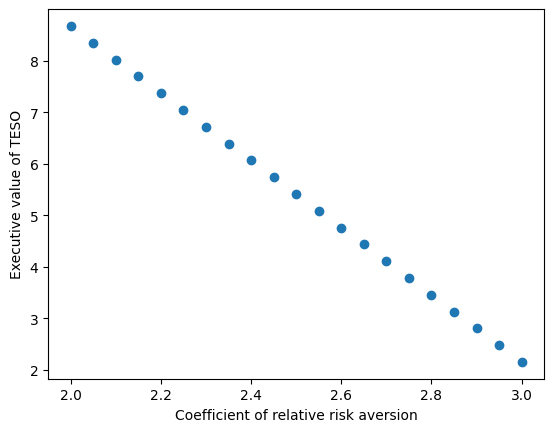

In [100]:
#COMPUTE TESO FOR DIFFERENT RISK AVERSIONS 

rhos_rn = 2 + np.arange(0,21)*0.05
print(rhos_rn)

#VALUE OF TESOs
start_time = time.time()



tesos = [CE_rn(S0_init, K_init, T_init, v_init, r_init, N_init, sigma_init, rho, n_s_init, n_o_init, c_init) for rho in rhos_rn]
print("--- %s seconds ---" % (time.time() - start_time))



print(tesos)

plt.scatter(rhos_rn, tesos)
plt.xlim(1.95, 3.05)
plt.xlabel('Coefficient of relative risk aversion')
plt.ylabel('Executive value of TESO')


plt.show()



In [101]:
#COMPUTE DESOs FOR DIFFERENT RISK AVERSIONS 

rhos = 2 + np.arange(0,5)*0.25
print(rhos)

#VALUE OF DESOs

desos = np.zeros(6)
count=0

for rho in rhos:
    start_time = time.time()
    desos[count] = CE_r(S0_init, K_init, T_init, v_init, r_init, N_init, sigma_init, rho, alpha_init, 0, n_s_init, n_o_init, c_init)
        #Gamma = 0 to simulate DESO
    count+=1
    print("--- %s seconds ---" % (time.time() - start_time))

print(desos)


#Plot
plt.scatter(rhos, desos)
plt.xlim(1.95, 3.05)
plt.xlabel('Coefficient of relative risk aversion')
plt.ylabel('Executive value of DESO')
plt.show()

[2.   2.25 2.5  2.75 3.  ]
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
4

KeyboardInterrupt: 

In [102]:
print(desos)


[2601.29357246    0.            0.            0.            0.
    0.        ]


*   [WROTE] Compute TESO and DESO 
    * With changing wealth (50/50)

*   Fixed the parameters
    * Change T, v, sigma, ...

*   Subjective (and objective) incentive
    * Change rho
    * Change alpha
    * Change gamma
    * Change ptf composition

*   Deadweight cost
    * Change gamma
    * Change alpha
    * Change ptf composition

*   Cost ratio
    * Change rho
    * Change alpha
    * Change ptf composition 


--- 7.001814842224121 seconds ---
[2.302889477244268, 1.9767118815456828, 1.6505754448318233, 1.3244788952140758, 0.9984209618003418, 0.6724003746174276, 0.3464158646700283, 0.02046616383517782, -0.30544999505393206, -0.6313338782917708, -0.9571867513967057, -1.2830098789030064, -1.6088045246526599, -1.9345719516432534, -2.26031342203108, -2.5860301972553135, -2.9117235380038617, -3.2373947042413054, -3.563044955187167, -3.8886755493748932, -4.214287744735678]
[13.900422073115283, 13.712621606718749, 13.52486852546533, 13.337162395858517, 13.149502784985428, 12.961889260417472, 12.774321390281742, 12.586798743195832, 12.399320888333023, 12.211887395394346, 12.024497834484404, 11.837151776365936, 11.649848792177314, 11.462588453572243, 11.27537033278495, 11.088194002450134, 10.901059035730238, 10.713965006234746, 10.526911488091573, 10.339898055900509, 10.152924284652496]


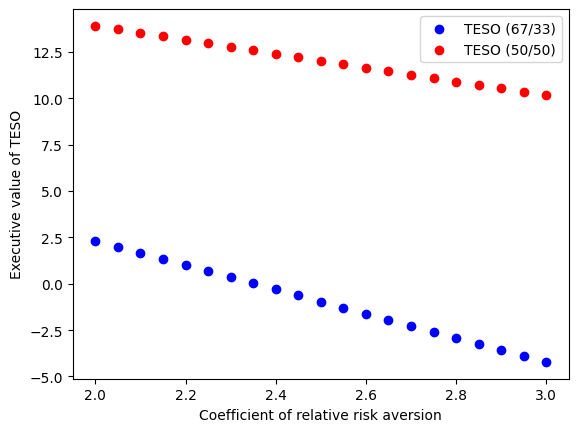

In [99]:
#COMPUTE TESO FOR DIFFERENT RISK AVERSIONS - WEALTH 50/50

rhos_rn = 2 + np.arange(0,21)*0.05

#VALUE OF TESOs
start_time = time.time()

tesos_ptf50 = [CE_rn(S0_init, K_init, T_init, v_init, r_init, N_init, sigma_init, rho, 83333, n_o_init, 2500000) for rho in rhos_rn]
print("--- %s seconds ---" % (time.time() - start_time))


print(tesos)
print(tesos_ptf50)



#Plot
plt.scatter(rhos_rn, tesos, label='TESO (67/33)', color='blue')
plt.scatter(rhos_rn, tesos_ptf50, label='TESO (50/50)', color='red')
plt.xlim(1.95, 3.05)
plt.xlabel('Coefficient of relative risk aversion')
plt.ylabel('Executive value of TESO')
plt.legend()
plt.show()
